In [1]:
from collections import Counter
import csv

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as sndi

%matplotlib inline

In [2]:
drive_log_file = 'driving_log.csv'

In [3]:
X_center = []
X_left = []
X_right = []
y_steering = []

with open(drive_log_file, 'rt') as csvfile:
    reader = csv.reader(csvfile, skipinitialspace=True)

    next(reader) # skip the first row
    
    i = 0
    for row in reader:
        i = i+1
        X_center.append(row[0])
        X_left.append(row[1])
        X_right.append(row[2])
        y_steering.append(float(row[3]))

X_center = np.array(X_center)
X_left = np.array(X_left)
X_right = np.array(X_right)
y_steering = np.array(y_steering)

# Data exploration

## 1. Steering angles

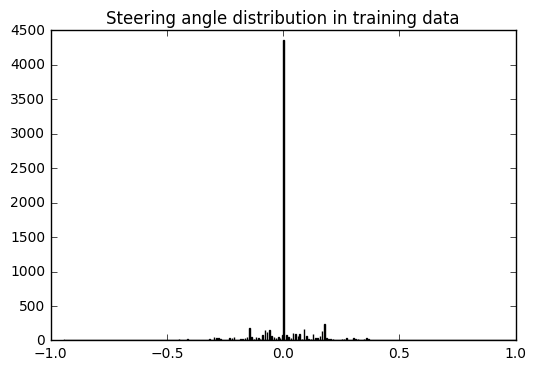

In [4]:
plt.title("Steering angle distribution in training data")
plt.hist(y_steering, 1000)
plt.show()

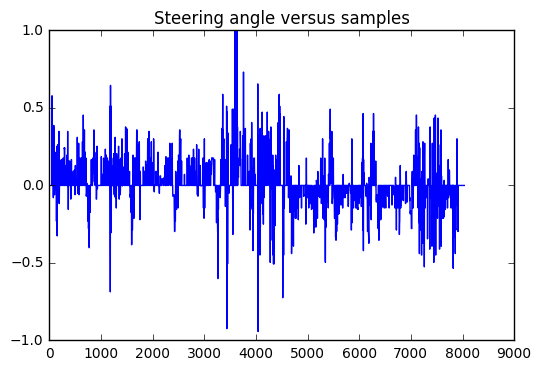

number of positive angle: 1900
number of negative angle: 1775
number of zero angle: 4361


In [5]:
plt.title("Steering angle versus samples")
plt.plot(y_steering)
plt.show()

positive_angle = [i for i in y_steering if i > 0]
nagative_angle = [i for i in y_steering if i < 0]
zero_angle = [i for i in y_steering if i == 0]

print('number of positive angle:', len(positive_angle))
print('number of negative angle:', len(nagative_angle))
print('number of zero angle:', len(zero_angle))

As I mentioned, number of zero angle case in the data is much higher then the others. Although number of positive angles are higher then that of negative angles, the difference is small, and should not affect our training.

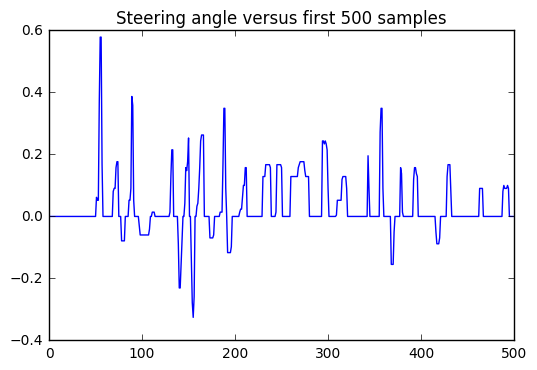

In [6]:
plt.title("Steering angle versus first 500 samples")
plt.plot(y_steering[0:500])
plt.show()

Steering angle changes while arrow keys are pressed, as a result, the changes in steering angle is sharp. However, in reality, the steering angle should be changed smoothly.

We may need to apply a smoother on the data.

## 2. Camera images

Sample images from different cameras


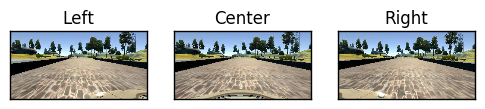

In [7]:
print("Sample images from different cameras")
fig = plt.figure()

a=fig.add_subplot(1,3,1)
img = mpimg.imread(X_left[0])
imgplot = plt.imshow(img)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Left')

a=fig.add_subplot(1,3,2)
img = mpimg.imread(X_center[0])
imgplot = plt.imshow(img)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Center')

a=fig.add_subplot(1,3,3)
img = mpimg.imread(X_right[0])
imgplot = plt.imshow(img)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Right')

Each sample contains three images from different cameras, each camera points at different angle.

Besides the center camera images, we may use other camera images to teach our network.

# Preprocessing

## 1. Gaussian Filter

I choose Gaussian filter to smooth the curve, because it is simple and efficient.

In [13]:
func = lambda x: np.mean(x)
data = y_steering
smoothed_y_steering = sndi.gaussian_filter(data, [1])

print(smoothed_y_steering)
print(y_steering)

[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]


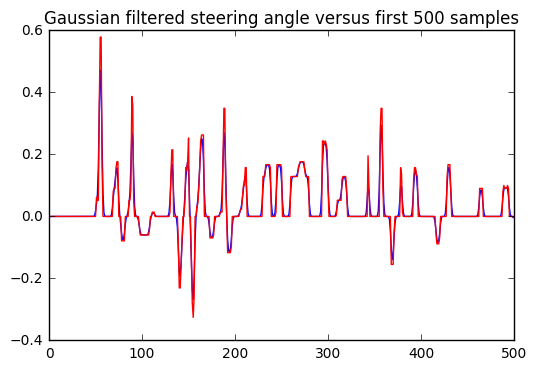

In [14]:
plt.title("Gaussian filtered steering angle versus first 500 samples")
plt.plot(smoothed_y_steering[0:500])
plt.plot(y_steering[0:500], color="red")
plt.show()

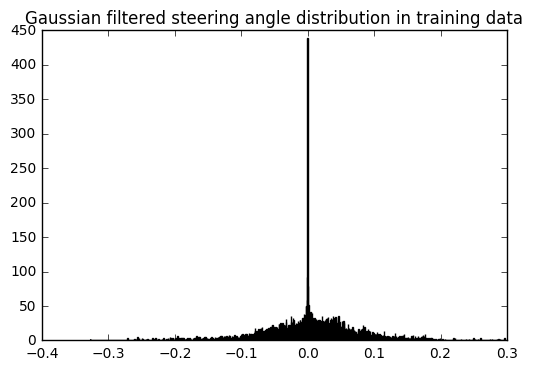

In [11]:
plt.title("Gaussian filtered steering angle distribution in training data")
plt.hist(smoothed_y_steering, 1000)
plt.show()

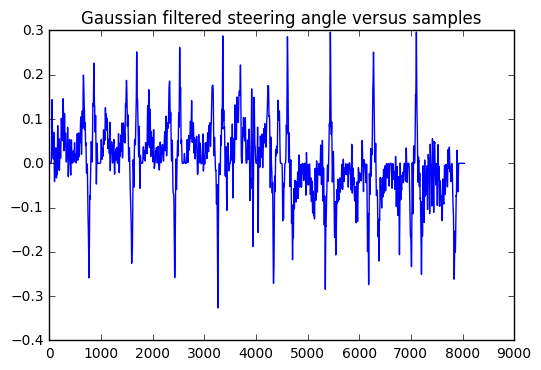

In [12]:
plt.title("Gaussian filtered steering angle versus samples")
plt.plot(smoothed_y_steering)
plt.show()

After applying Gaussian filter, the number of sample with *steering angle == 0* decreases, and the range of steering angle reduces.

## 2. Use side camera images

In [ ]:
def get_image_with_steering_angle_in_range(position, min_angle, max_angle):
    for i in range(len(y_steering)):
        if y_steering[i] >= min_angle and y_steering[i] <= max_angle:
            if position == 'center':
                img = mpimg.imread(X_center[i])
            elif position == 'left':
                img = mpimg.imread(X_left[i])
            elif position == 'right':
                img = mpimg.imread(X_right[i])
            return img, y_steering[i]

In [ ]:
fig = plt.figure()

img, angle = get_image_with_steering_angle_in_range('center', 0.15, 0.25)
a=fig.add_subplot(2,1,1)
imgplot = plt.imshow(img)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Center image with angle: ' + str(angle))

img, angle = get_image_with_steering_angle_in_range('left', -0.05, 0.05)
a=fig.add_subplot(2,1,2)
imgplot = plt.imshow(img)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Left image with angle: ' + str(angle))

I think left camera image at *steering angle == 0* looks similar to the center camera image at *stering angle == ~0.5*, so I will use left camera images for training, with a steering angle offset **0.15**

Obviously, images from right camera should look similar to center camera image, with an offset steering angle **-0.15**

## 3. Flip the image horizontally

If we flip the image with steering angle **x** horizontally, then we should have an image with steering angle **-x**. We can use this trick to double our sample size.

In [ ]:
fig = plt.figure()

img, angle = get_image_with_steering_angle_in_range('center', 0.4, 0.5)
a=fig.add_subplot(2,1,1)
imgplot = plt.imshow(img)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Center image with angle: ' + str(angle))

a=fig.add_subplot(2,1,2)
flipped_img = cv2.flip(img, flipCode=1)
imgplot = plt.imshow(flipped_img)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
a.set_title('Center image with angle: ' + str(-angle))